# Online Retail Simulator

This notebook provides a high-level overview of the [**Online Retail Simulator**](https://github.com/eisenhauerIO/tools-catalog-generator) and sets the context for the causal analyses that follow.

![description](online-retail-simulator.png)

The simulator operates in three phases. First, it generates a product catalog with key characteristics such as category and price tier. Second, it enriches each product with detailed content including brand names, titles, descriptions, and feature lists. Third, it simulates sales transactions with realistic temporal patterns and conversion metrics. You can choose between rule-based generation, which is deterministic and interpretable, and synthesizer-based generation, which learns patterns from your own data. An enrichment layer then allows you to inject known treatment effects—such as a quantity boost or a gradual rollout—so you can validate whether your causal models recover the true effect size.

## Setup

We start by installing the package directly from its [GitHub](https://github.com/eisenhauerIO/tools-catalog-generator) repository. Then we are ready to import the **Online Retail Simulator** just as any other package.

In [ ]:
# Standard Library
from operator import itemgetter
import inspect

# Third-party packages
from IPython.display import Code
import pandas as pd

from online_retail_simulator import simulate, load_job_results

# Local imports
from support import (
    plot_revenue_by_category,
    plot_daily_metrics_trend,
    plot_conversion_funnel,
    plot_treatment_effect,
)

### Generate Sample Data

Let's start by simulating 100 products. The configuration drives a three-phase simulation and is defined using [YAML](https://yaml.org/). 

The **CHARACTERISTICS** section generates the product catalog—what you're selling, including product identifiers, categories, and prices. The **PARAMS** subsection controls how many products to generate and sets the random seed for reproducibility.

The **PRODUCT_DETAILS** section enriches each product with realistic titles, descriptions, brands, and feature lists using rule-based templates. Here we use `simulate_product_details_mock` which generates simple placeholder content.

The **METRICS** section simulates daily sales transactions for those products over a date range, modeling the full customer journey from impressions through visits, cart adds, and orders. The **PARAMS** subsection defines the simulation period and the base probability that a product gets a sale on any given day.

In [ ]:
! cat "config_simulation.yaml"

STORAGE:
  PATH: output

RULE:
  CHARACTERISTICS:
    FUNCTION: simulate_characteristics_rule_based
    PARAMS:
      num_products: 100
      seed: 42

  METRICS:
    FUNCTION: simulate_metrics_rule_based
    PARAMS:
      date_start: "2024-11-01"
      date_end: "2024-11-30"
      sale_prob: 0.7
      seed: 42

PRODUCT_DETAILS:
  FUNCTION: simulate_product_details_mock


To understand how the simulation functions work under the hood, you can explore their source code directly. Python's `inspect` module lets you view the implementation right inside the notebook, or you can browse the source files on GitHub ([characteristics](https://github.com/eisenhauerIO/tools-catalog-generator/blob/main/online_retail_simulator/simulate/characteristics_rule_based.py), [product_details](https://github.com/eisenhauerIO/tools-catalog-generator/blob/main/online_retail_simulator/simulate/product_details_mock.py), [metrics](https://github.com/eisenhauerIO/tools-catalog-generator/blob/main/online_retail_simulator/simulate/metrics_rule_based.py)) or the API documentation ([characteristics](https://eisenhauerio.github.io/tools-catalog-generator/_modules/online_retail_simulator/simulate/characteristics_rule_based.html#simulate_characteristics_rule_based), [product_details](https://eisenhauerio.github.io/tools-catalog-generator/_modules/online_retail_simulator/simulate/product_details_mock.html#simulate_product_details_mock), [metrics](https://eisenhauerio.github.io/tools-catalog-generator/_modules/online_retail_simulator/simulate/metrics_rule_based.html#simulate_metrics_rule_based)).

In [ ]:
from online_retail_simulator.simulate.characteristics_rule_based import simulate_characteristics_rule_based

Code(inspect.getsource(simulate_characteristics_rule_based), language="python")

def simulate_characteristics_rule_based(config: Dict) -> pd.DataFrame:
    """
    Generate synthetic product characteristics (rule-based).
    Args:
        config: Complete configuration dictionary
    Returns:
        DataFrame of product characteristics
    """
    params = config["RULE"]["CHARACTERISTICS"]["PARAMS"]
    num_products, seed = params["num_products"], params["seed"]

    if seed is not None:
        random.seed(seed)
    products: List[Dict] = []
    for i in range(num_products):
        category = random.choice(_CATEGORIES)
        price_min, price_max = _PRICE_RANGES[category]
        price = round(random.uniform(price_min, price_max), 2)
        products.append(
            {
                "product_identifier": generate_random_product_identifier(),
                "category": category,
                "price": price,
            }
        )
    return pd.DataFrame(products)

In [ ]:
from online_retail_simulator.simulate.product_details_mock import (
    simulate_product_details_mock,
)

Code(inspect.getsource(simulate_product_details_mock), language="python")

Now, lets look at the data.

Calling `simulate("config_simulation.yaml")` triggers a three-phase data generation process. First, it reads and validates the YAML configuration, then runs the **characteristics** phase to create a product catalog with the specified number of products, assigning each a unique identifier, category, and price. Second, it runs the **product_details** phase to enrich each product with brand names, titles, descriptions, and feature lists. Third, it runs the **metrics** phase, simulating a customer conversion funnel (impressions, visits, cart additions, orders, and revenue) for each product across the defined date range. The function writes the generated DataFrames to disk and returns a `JobInfo` object that tracks where the results are stored—which you then pass to `load_job_results()` to retrieve the data.

The products data represents the catalog of items available for sale. Each product starts with core **characteristics**—a unique **product_identifier**, **category** (such as Electronics, Clothing, or Books), **brand**, and **price**—which are then enriched with **product_details** including **title**, **description**, and **features**. These attributes influence the simulated sales behavior—for example, higher-priced items may have different conversion patterns than low-cost products, and categories can exhibit distinct purchasing dynamics.

In [ ]:
job_info = simulate("config_simulation.yaml")

products, metrics = itemgetter("products", "sales")(load_job_results(job_info))

In [ ]:
products.head()

,product_identifier,category,price,title,description,brand,features
0,BRPOIG8F1C,Clothing,19.63,StyleFit Premium Clothing Item,Quality clothing product for everyday use. Bre...,StyleFit,"['Breathable fabric', 'Wrinkle resistant', 'Qu..."
1,BO6B9M80O2,Electronics,185.86,TechPro Advanced Electronics Item,Quality electronics product for everyday use. ...,TechPro,"['Voice control', 'Bluetooth connectivity', 'F..."
2,BAK1VRJNVG,Sports & Outdoors,245.69,ValueBrand Essential Sports & Outdoors Item,Quality sports & outdoors product for everyday...,ValueBrand,"['Easy to use', 'Durable construction', 'Great..."
3,BWWQC38HYF,Clothing,85.29,ClassicWear Lightweight Clothing Item,Quality clothing product for everyday use. Wri...,ClassicWear,"['Wrinkle resistant', 'Machine washable', 'Str..."
4,BXMECOSFOG,Sports & Outdoors,251.38,TrustMark Professional Sports & Outdoors Item,Quality sports & outdoors product for everyday...,TrustMark,"['Great value', 'High quality materials', 'Eas..."


The metrics data captures the full customer journey as a conversion funnel. Each record tracks how many times a product was shown to customers (**impressions**), how many clicked through to view it (**visits**), how many added it to their cart (**cart_adds**), and how many ultimately purchased (**ordered_units**). This funnel structure reflects real e-commerce behavior where customers drop off at each stage, letting you analyze conversion rates and identify where customers are lost in the purchase process.


In [ ]:
metrics.sort_values(["product_identifier", "date"]).head()

## Exploring the Generated Data

Let's look at the structure and contents of our synthetic dataset.

In [ ]:
"""Print formatted summary of metrics data."""
print("=" * 40)
print("DATA SUMMARY")
print("=" * 40)
print(f"What is the date range?       {metrics['date'].min()} to {metrics['date'].max()}")
print(f"How many categories?          {metrics['category'].nunique()}")
print(f"What is the total revenue?    ${metrics['revenue'].sum():,.2f}")
print("=" * 40)

How is revenue distributed across product categories?

In [ ]:
category_revenue = metrics.groupby("category")["revenue"].sum().sort_values()
plot_revenue_by_category(category_revenue)

In [59]:
Code(inspect.getsource(plot_revenue_by_category), language="python")

def plot_revenue_by_category(category_revenue):
    """
    Plot horizontal bar chart of revenue by category.

    Parameters
    ----------
    category_revenue : pandas.Series
        Series with category names as index and revenue values.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    category_revenue.plot(kind="barh", ax=ax, color=sns.color_palette("viridis", len(category_revenue)))
    ax.set_xlabel("Revenue ($)")
    ax.set_ylabel("Category")
    ax.set_title("Total Revenue by Category")
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"${x:,.0f}"))
    plt.tight_layout()
    plt.show()

How do metrics vary over time?

In [ ]:
# Daily metrics trend
daily_metrics = metrics.groupby("date").agg({"ordered_units": "sum", "revenue": "sum"}).reset_index()
daily_metrics["date"] = pd.to_datetime(daily_metrics["date"])

plot_daily_metrics_trend(daily_metrics)

How do customers move through the purchase journey?

In [ ]:
funnel_data = {
    "Impressions": metrics["impressions"].sum(),
    "Visits": metrics["visits"].sum(),
    "Cart Adds": metrics["cart_adds"].sum(),
    "Orders": metrics["ordered_units"].sum(),
}

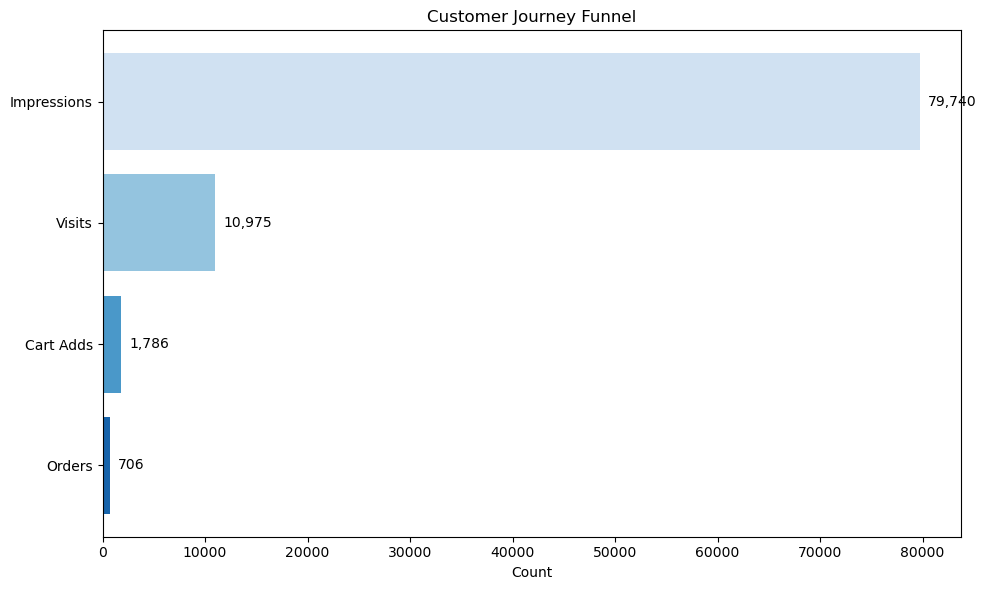

In [62]:
plot_conversion_funnel(funnel_data)

In [63]:
print("=" * 55)
print("CONVERSION RATES")
print("=" * 55)
print(f"What fraction of impressions become visits?   {funnel_data['Visits'] / funnel_data['Impressions'] * 100:.1f}%")
print(f"What fraction of visits add to cart?          {funnel_data['Cart Adds'] / funnel_data['Visits'] * 100:.1f}%")
print(f"What fraction of cart adds become orders?     {funnel_data['Orders'] / funnel_data['Cart Adds'] * 100:.1f}%")
print(f"What is the overall conversion rate?          {funnel_data['Orders'] / funnel_data['Impressions'] * 100:.2f}%")
print("=" * 55)

CONVERSION RATES
What fraction of impressions become visits?   13.8%
What fraction of visits add to cart?          16.3%
What fraction of cart adds become orders?     39.5%
What is the overall conversion rate?          0.89%


## Vibe Coding: Exploring the Data

**Vibe coding** is a development style where you describe *what* you want in natural language and let AI assistants generate the code. Rather than manually writing every line, you focus on asking the right questions and guiding the output. This approach accelerates exploratory data analysis, letting you iterate quickly through hypotheses without getting bogged down in syntax.

In this section, we use [GitHub Copilot](https://github.com/features/copilot) to generate descriptive plots on the fly. We ask a question, sketch the intent, and let Copilot fill in the details. The goal is not perfectly polished code—it's rapid insight generation. Once we find something interesting, we can refine and formalize it later.

**Revenue Analysis**

* Which category generates the most revenue?
* What are the top 10 products by revenue?
* How does daily revenue change over time?

**Product Performance**

* Which products have the most impressions but lowest conversion?
* What is the distribution of ordered units per product?

## Enrichment: Simulating Treatment Effects

The package can simulate treatment effects by boosting sales for a subset of products starting at a specific date. This models a common e-commerce experiment: **Does improving product content quality increase sales?**

In a real A/B test, you might enhance product titles, descriptions, and feature lists for a treatment group while keeping control products unchanged. The simulator supports this through two mechanisms:

1. **Product Details with Treatment Mode**: Generate enhanced product copy (stronger brand names, more compelling descriptions, better feature highlights)
2. **Sales Enrichment**: Apply the corresponding sales uplift that improved content would produce

The **ENRICHMENT** configuration controls the treatment parameters. The `effect_size` controls the magnitude of the boost (0.5 = 50% increase), `enrichment_fraction` determines what share of products receive treatment (1.0 = 100%), and `enrichment_start` sets when the intervention begins. The `ramp_days` parameter models a gradual rollout where the effect linearly increases over the specified number of days, mimicking real-world deployment patterns.

In [64]:
print(open("config_enrichment_mock.yaml").read())

IMPACT:
  FUNCTION: quantity_boost
  PARAMS:
    effect_size: 0.5
    ramp_days: 0
    enrichment_fraction: 1.0
    enrichment_start: "2024-11-15"
    seed: 42



In [65]:
from online_retail_simulator.enrich.enrichment_library import quantity_boost

Code(inspect.getsource(quantity_boost), language="python")

def quantity_boost(sales: list, **kwargs) -> tuple:
    """
    Boost ordered units by a percentage for enriched products.

    Args:
        sales: List of sale transaction dictionaries
        **kwargs: Parameters including:
            - effect_size: Percentage increase in ordered units (default: 0.5 for 50% boost)
            - enrichment_fraction: Fraction of products to enrich (default: 0.3)
            - enrichment_start: Start date of enrichment (default: "2024-11-15")
            - seed: Random seed for product selection (default: 42)
            - min_units: Minimum units for enriched products with zero sales (default: 1)

    Returns:
        Tuple of (treated_sales, potential_outcomes_df):
            - treated_sales: List of modified sale dictionaries with treatment applied
            - potential_outcomes_df: DataFrame with Y0_revenue and Y1_revenue for all products
    """
    effect_size = kwargs.get("effect_size", 0.5)
    enrichment_fraction = kwargs.get("enrichment_fraction", 0.3)
    enrichment_start = kwargs.get("enrichment_start", "2024-11-15")
    seed = kwargs.get("seed", 42)
    min_units = kwargs.get("min_units", 1)

    if seed is not None:
        random.seed(seed)

    unique_products = list(set(sale["product_id"] for sale in sales))
    n_enriched = int(len(unique_products) * enrichment_fraction)
    enriched_product_ids = set(random.sample(unique_products, n_enriched))

    treated_sales = []
    potential_outcomes = {}  # {(product_id, date): {'Y0_revenue': x, 'Y1_revenue': y}}
    start_date = datetime.strptime(enrichment_start, "%Y-%m-%d")

    for sale in sales:
        sale_copy = copy.deepcopy(sale)
        product_id = sale_copy["product_id"]
        sale_date_str = sale_copy["date"]
        sale_date = datetime.strptime(sale_date_str, "%Y-%m-%d")

        is_enriched = product_id in enriched_product_ids
        sale_copy["enriched"] = is_enriched

        # Calculate Y(0) - baseline revenue (no treatment)
        y0_revenue = sale_copy["revenue"]

        # Calculate Y(1) - revenue if treated (for ALL products)
        unit_price = sale_copy.get("unit_price", sale_copy.get("price"))
        if sale_date >= start_date:
            original_quantity = sale_copy["ordered_units"]
            boosted_quantity = int(original_quantity * (1 + effect_size))
            boosted_quantity = max(min_units, boosted_quantity)
            y1_revenue = round(boosted_quantity * unit_price, 2)
        else:
            # Before treatment start, Y(1) = Y(0)
            y1_revenue = y0_revenue

        # Store potential outcomes for ALL products
        key = (product_id, sale_date_str)
        potential_outcomes[key] = {"Y0_revenue": y0_revenue, "Y1_revenue": y1_revenue}

        # Apply factual outcome (only for treated products)
        if is_enriched and sale_date >= start_date:
            sale_copy["ordered_units"] = boosted_quantity
            sale_copy["revenue"] = y1_revenue

        treated_sales.append(sale_copy)

    # Build potential outcomes DataFrame
    potential_outcomes_df = pd.DataFrame(
        [
            {
                "product_identifier": pid,
                "date": d,
                "Y0_revenue": v["Y0_revenue"],
                "Y1_revenue": v["Y1_revenue"],
            }
            for (pid, d), v in potential_outcomes.items()
        ]
    )

    return treated_sales, potential_outcomes_df

### Control vs Treatment Product Content

The `simulate_product_details_mock` function accepts a `treatment_mode` parameter that generates enhanced product copy. Let's compare what control and treatment content look like for the same product.

In [66]:
from online_retail_simulator.simulate.product_details_mock import (
    simulate_product_details_mock,
)

# Create a sample product to compare
sample_product = products[["product_identifier", "category", "price"]].head(1)

# Generate control (standard) and treatment (enhanced) content
control = simulate_product_details_mock(sample_product, seed=42, treatment_mode=False)
treatment = simulate_product_details_mock(sample_product, seed=42, treatment_mode=True)

print("=" * 70)
print("CONTROL GROUP (Standard Content)")
print("=" * 70)
print(f"Brand:       {control.iloc[0]['brand']}")
print(f"Title:       {control.iloc[0]['title']}")
print(f"Description: {control.iloc[0]['description']}")
print(f"Features:    {control.iloc[0]['features']}")

print("\n" + "=" * 70)
print("TREATMENT GROUP (Enhanced Content)")
print("=" * 70)
print(f"Brand:       {treatment.iloc[0]['brand']}")
print(f"Title:       {treatment.iloc[0]['title']}")
print(f"Description: {treatment.iloc[0]['description']}")
print(f"Features:    {treatment.iloc[0]['features']}")

CONTROL GROUP (Standard Content)
Brand:       UrbanWear
Title:       UrbanWear Comfortable Clothing Item
Description: Quality clothing product for everyday use. Wrinkle resistant. Breathable fabric.
Features:    ['Wrinkle resistant', 'Breathable fabric', 'Machine washable', 'Quick dry']

TREATMENT GROUP (Enhanced Content)
Brand:       UrbanWear Elite
Title:       UrbanWear Elite Luxurious Clothing Item
Description: Premium clothing product with exceptional quality. Permanent wrinkle-free technology. Advanced moisture-wicking fabric.
Features:    ['Permanent wrinkle-free technology', 'Advanced moisture-wicking fabric', 'Easy-care machine washable', 'Rapid-dry technology']


Notice how treatment mode generates more compelling content: brand names get premium suffixes ("Elite", "Pro"), adjectives become stronger ("Revolutionary" vs "Advanced"), and feature descriptions are more specific ("Industry-leading battery life" vs "Long battery life"). This simulates what a content optimization team might produce.

The `quantity_boost` enrichment function then models the sales impact of this improved content—the hypothesis being that better product descriptions convert more browsers into buyers.

Calling `enrich("config_enrichment_mock.yaml", job_info)` applies the treatment effect to the simulated data. The function selects 30% of products as the treatment group and boosts their sales metrics starting November 15th. The effect ramps up linearly over 7 days, reaching the full 50% boost by November 22nd. The enriched DataFrame contains a new `is_treated` column indicating which products received the intervention.

In [ ]:
from online_retail_simulator import simulate, load_job_results

job_info = simulate("config_simulation.yaml")

products, metrics = itemgetter("products", "sales")(load_job_results(job_info))

Now we need to apply the enrichment.

In [68]:
from online_retail_simulator import enrich

enriched_job = enrich("config_enrichment_mock.yaml", job_info)
enriched = load_job_results(enriched_job)

In [69]:
enriched["enriched"].columns

Index(['product_identifier', 'category', 'price', 'title', 'description',
       'brand', 'features', 'date', 'impressions', 'visits', 'cart_adds',
       'ordered_units', 'revenue', 'enriched'],
      dtype='object')

In [70]:
from online_retail_simulator import enrich

enriched_job = enrich("config_enrichment_mock.yaml", job_info)
enriched = load_job_results(enriched_job)["enriched"]

In [71]:
print(enriched.columns.tolist())

['product_identifier', 'category', 'price', 'title', 'description', 'brand', 'features', 'date', 'impressions', 'visits', 'cart_adds', 'ordered_units', 'revenue', 'enriched']


In [ ]:
plot_treatment_effect(metrics, enriched, "2024-11-15")